In [23]:
# Import modules
import sys
import os
import numpy as np
import math
import matplotlib
#matplotlib.use('Agg')
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import cm
import scipy.signal
import pandas as pd
import pyranges
import itertools
import csv
from joblib import Parallel, delayed
import cv2
from scipy import ndimage
import seaborn as sns; sns.set(color_codes=True)
from sklearn.cluster import DBSCAN 
%matplotlib inline

In [290]:
# Define auxiliary functions
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

def use_less_memory(df):
    # Converts datafreme columns into int and categorical if appropriate
    import pandas as pd
    # Converting numbers into int8
    gl_int = df.select_dtypes(include=['int'])
    converted_int = gl_int.apply(pd.to_numeric,downcast='unsigned')
    df[converted_int.columns] = converted_int
    # Converting objects into category
    gl_obj = df.select_dtypes(include=['object']).copy()
    converted_obj = pd.DataFrame()
    for col in gl_obj.columns:
        num_unique_values = len(gl_obj[col].unique())
        num_total_values = len(gl_obj[col])
        if num_unique_values / num_total_values < 0.5:
            converted_obj.loc[:,col] = gl_obj[col].astype('category')
        else:
            converted_obj.loc[:,col] = gl_obj[col]
        df[converted_obj.columns] = converted_obj
    return df

def HM_bins(dataframe,name_png,cmap_col = "Oranges",size = [24,30]):
    fig, ax = plt.subplots()
    im = ax.imshow(dataframe,cmap=cmap_col,vmin=0, vmax=max(dataframe.values.max(),0.1))
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(dataframe.columns)))
    ax.set_yticks(np.arange(len(dataframe.index)))
    
    # ... and label them with the respective list entries
    ax.set_xticklabels(dataframe.columns)
    ax.set_yticklabels(dataframe.index)
    
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")
    cbar = ax.figure.colorbar(im, ax=ax,cmap=cmap_col)
    ax.set_title(name_png)
    plt.xlabel(dataframe.columns[1].split(':')[0])
    plt.ylabel(dataframe.index[1].split(':')[0])
    fig.tight_layout()
    
    #plt.show()
    figure = plt.gcf()
    figure.set_size_inches(size[0], size[1])
    
    plt.savefig(name_png +".png",dpi=100)
    #plt.savefig(name_png +".eps",dpi=100)
    plt.show()
    plt.close()

def make_bins(chrom_size,bin_size):
    for index, i in chrom_size.iterrows():
        if 'dfbins' in locals():
            dfbins= pd.concat([dfbins,pd.DataFrame({"Chromosome":i[0],"Start":(np.arange(0,i[1],bin_size)+1),\
                                                    "End":np.arange(0,(i[1]+bin_size),bin_size)[1:] })])
        else:
            dfbins=pd.DataFrame({"Chromosome":i[0],"Start":(np.arange(0,i[1],bin_size)+1),\
                                 "End":np.arange(0,(i[1]+bin_size),bin_size)[1:] })
    dfbins["Bin"]=dfbins.Chromosome+":"+dfbins.Start.map(str)+"-"+dfbins.End.map(str)
    return dfbins
def filtering_bins(dfbins,region1,region2,bin_size):
    region1=region1.replace(',', '')
    region2=region2.replace(',', '')
    region1_chr=region1.split(':')[0]
    region2_chr=region2.split(':')[0]
    region1_start=int(region1.split(':')[1].split('-')[0])-bin_size
    region2_start=int(region2.split(':')[1].split('-')[0])-bin_size
    region1_end=int(region1.split(':')[1].split('-')[1])+bin_size
    region2_end=int(region2.split(':')[1].split('-')[1])+bin_size
    dfbins1=dfbins[dfbins.Chromosome==region1_chr]
    #dfbins1=dfbins1[(dfbins1.columns.str.startswith('Start')>=region1_start) & (dfbins1.columns.str.startswith('End')<=region1_end)]
    #df.loc[:, dfbins1.columns.str.startswith('Start')]
    dfbins1=dfbins1[(dfbins1.Start>=region1_start) & (dfbins1.End<=region1_end)]
    dfbins2=dfbins[dfbins.Chromosome==region2_chr]
    dfbins2=dfbins2[(dfbins2.Start>=region2_start) & (dfbins2.End<=region2_end)]
    dfbins_fin=pd.concat([dfbins1,dfbins2])
    return dfbins_fin

In [7]:
# Reading data
bin_size=100000
patient="P11603_125"
path="/Users/lucia.pena.perez/OneDrive - KI.SE/MANUSCRIPTS 10x lrWGS genetics/Data/lrwgs_barcrawler/barcrawler-results-"
file_name="/phased_possorted_bam_MoleculeSpan.tab"
path_hg38_size="/Users/lucia.pena.perez/OneDrive - KI.SE/temp foxo/MM/Hg38-chromosome-size.txt"
chromosomes=["chr"+ str(int(x)) for x in np.linspace(1,22,num=22)]
df_all=pd.read_csv(path+patient+file_name, sep='\t', engine='python')

# Filter unwanted chromosomes
df_all=df_all.loc[df_all['#chromosome'].isin(chromosomes)]

# Filtering those with less than 10 reads and shorter than 1kb
df_all=df_all[df_all.n_reads>=10]
df_all=df_all[(df_all.end-df_all.start)>=10000]
df_all=df_all[["#chromosome","start","start","BX"]]
df_all.columns=["Chromosome","Start","End","BX"]
if not os.path.exists(path+patient+"/chr-heatmaps/"):
    os.mkdir(path+patient+"/chr-heatmaps/")

# Making bins
chrom_size=pd.read_csv(path_hg38_size, sep='\t', engine='python',names=["chr_name","chr_len"])
dfbins=make_bins(chrom_size,bin_size)
dfbins=dfbins.loc[dfbins['Chromosome'].isin(chromosomes)]

# Filter bins
filter_bins = True

In [10]:
# Making Ranges
# This time with ALL bins and all BXs
sdfgr=pyranges.PyRanges(df_all)
dfbinsgr=pyranges.PyRanges(dfbins)

# Overlaping them
dfcomb_tot_interm=sdfgr.nearest(dfbinsgr, suffix="_bin")
dfcomb_tot=pd.DataFrame({"Bin":dfcomb_tot_interm.Bin.map(str),"BX":dfcomb_tot_interm.BX.map(str)})
        
# Droping duplicates (same bin and same BX)
dfcomb_tot=dfcomb_tot.drop_duplicates(['BX','Bin'])
#dfcomb_tot['BX'].value_counts().describe()


In [12]:
# Creating a square matrix with zeros where each bin is represented in order
# Subsetting dataframe to take only all BXs in all region
int_rowa=dfcomb_tot['Bin'].str.contains(":")
int_rowb=dfcomb_tot['Bin'].str.contains(":")
dfcomb_tota=dfcomb_tot[int_rowa]
dfcomb_totb=dfcomb_tot[int_rowb]

# Temp dataframe where cols and rows are the bins in chrom
temp=pd.DataFrame(0,columns=dfbins.Bin,index=dfbins.Bin)

Bin,chr1:1-100000,chr1:100001-200000,chr1:200001-300000,chr1:300001-400000,chr1:400001-500000,chr1:500001-600000,chr1:600001-700000,chr1:700001-800000,chr1:800001-900000,chr1:900001-1000000,...,chr22:49900001-50000000,chr22:50000001-50100000,chr22:50100001-50200000,chr22:50200001-50300000,chr22:50300001-50400000,chr22:50400001-50500000,chr22:50500001-50600000,chr22:50600001-50700000,chr22:50700001-50800000,chr22:50800001-50900000
Bin,,,,,,,,,,,,,,,,,,,,,
chr1:1-100000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr1:100001-200000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr1:200001-300000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr1:300001-400000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
chr1:400001-500000,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
# Filling in the df by finding all BX in each column and then checking how many are in each row too
# To make more efficient matrix should become triangular  
for column in temp:
    BXs=dfcomb_tota.BX[dfcomb_tota.Bin==column]
    bins=dfcomb_totb.Bin[dfcomb_totb.BX.isin(BXs)].value_counts()
    temp.loc[bins.index,column]=bins.values
        
diagon=np.diag(temp)+1
final_dataframe=((temp.div(diagon, axis=1)+temp.div(diagon, axis=0))/2)
ima=np.array(final_dataframe)
ima_med=ndimage.median_filter(ima, 2)
final_dataframe_filt=pd.DataFrame(ima_med, index=final_dataframe.index,columns=final_dataframe.columns)

In [ ]:
# DBSCAN implementation
rows_ima, cols_ima = np.where(ima_med!=0)
X=np.column_stack((rows_ima, cols_ima))
w=ima_med[np.where(ima_med!=0)]
#rows_ima, cols_ima = np.where(ima_med>=0)
#X=np.column_stack((rows_ima, cols_ima))
#w=ima_med[np.where(ima_med>=0)]
epsilon = 4
minimumSamples = 1
db = DBSCAN(eps=epsilon, min_samples=minimumSamples).fit(X,sample_weight=w)
labels = db.labels_

In [291]:
# Filtering unwanted clusters from DBSCAN
int_points=[]
all_lab_points_c=[]
all_lab_points_r=[]
if labels.max()>=0:
    for i in np.linspace(0,labels.max(),labels.max()+1):
        # Filtering events where a region is taken against itself
        blop_cols=cols_ima[labels==i]
        blop_rows=rows_ima[labels==i]
        if sum(blop_cols==blop_rows)==0:
            if len(all_lab_points_c)>0:
                # Filtering events found in both directions rc and cr, to make more efficient matrix should become triangular  
                if (len(np.where(np.in1d(blop_cols,np.concatenate(all_lab_points_r)))[0])<3) \
                & (len(np.where(np.in1d(blop_rows,np.concatenate(all_lab_points_c)))[0])<3):
                    all_lab_points_c.append(blop_cols)
                    all_lab_points_r.append(blop_rows)
                    int_points.append(i)
            else:
                all_lab_points_c.append(blop_cols)
                all_lab_points_r.append(blop_rows)
                int_points.append(i)
else:
    int_points=[]

Number of clusters
18
1.0


/var/folders/xx/n8fzttqj35db471_9hpyc88m0000gq/T/ipykernel_82528/3525592111.py:44: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  cbar = ax.figure.colorbar(im, ax=ax,cmap=cmap_col)


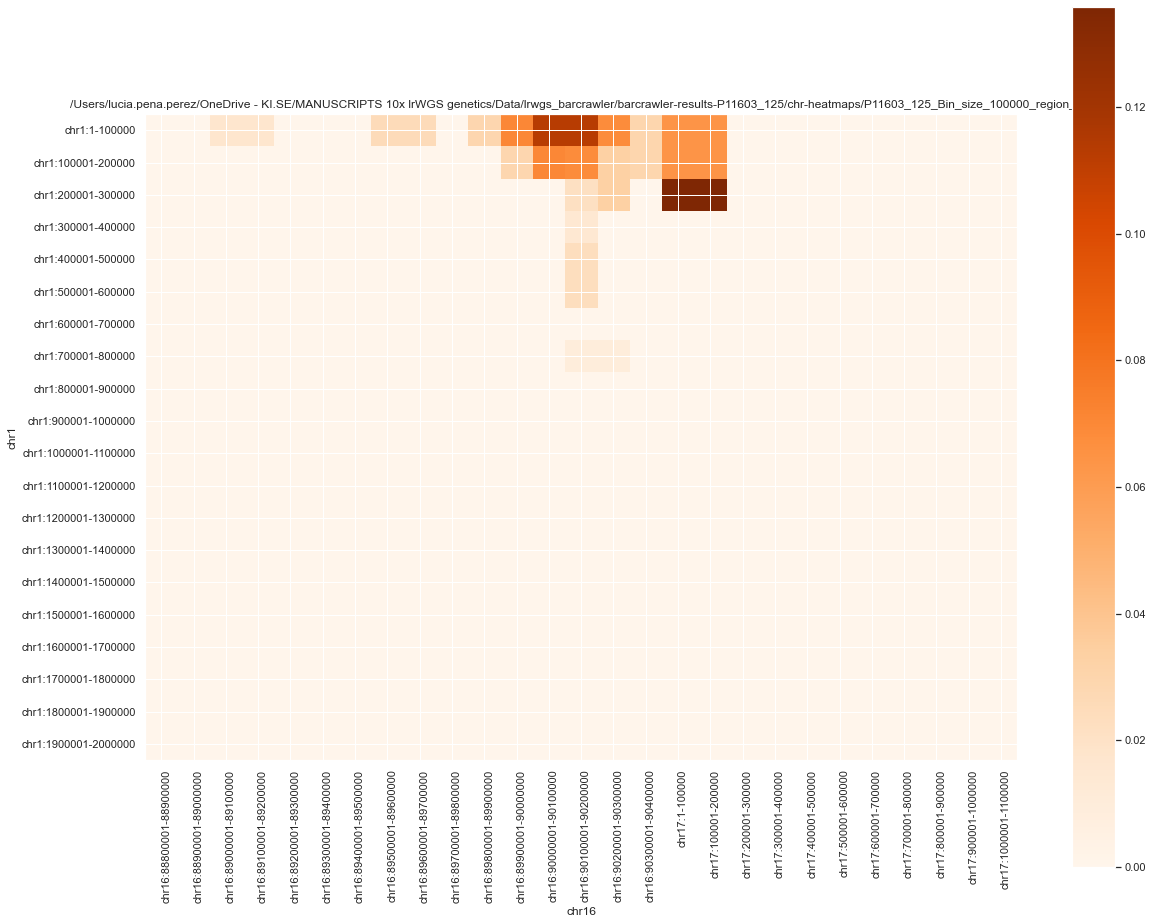

3.0


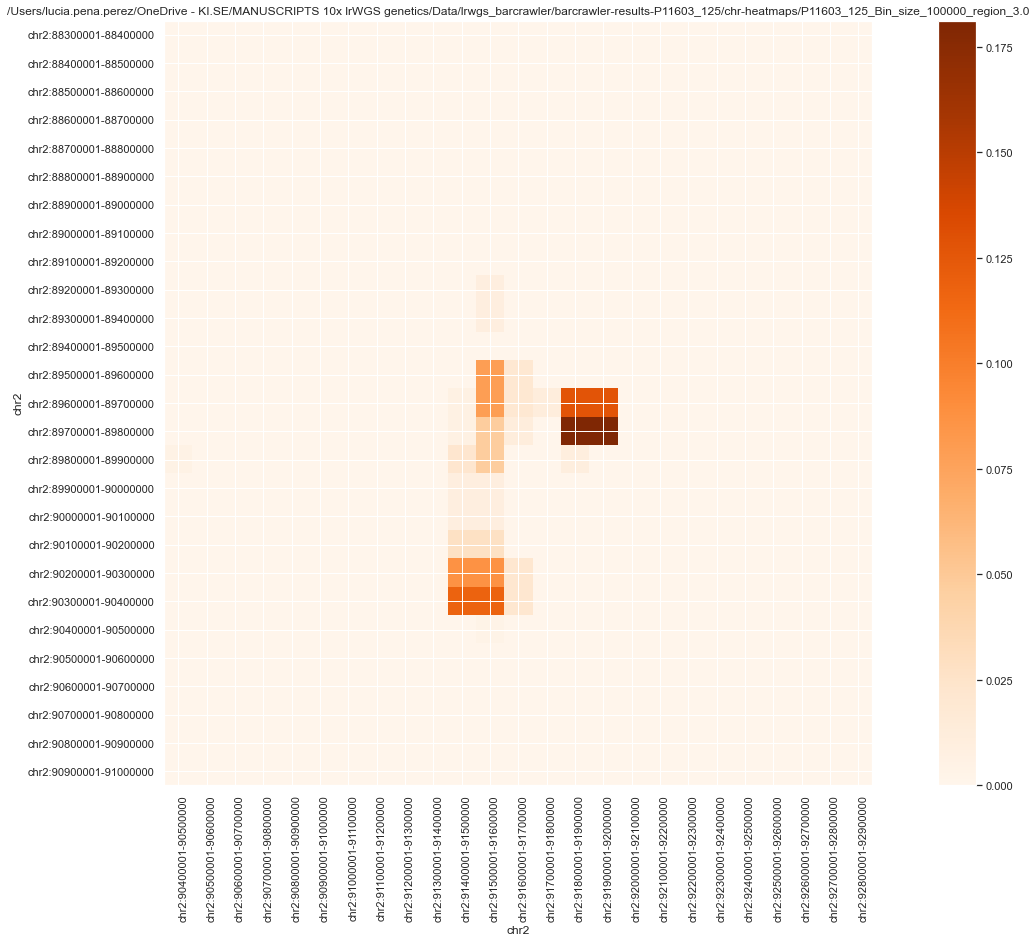

8.0


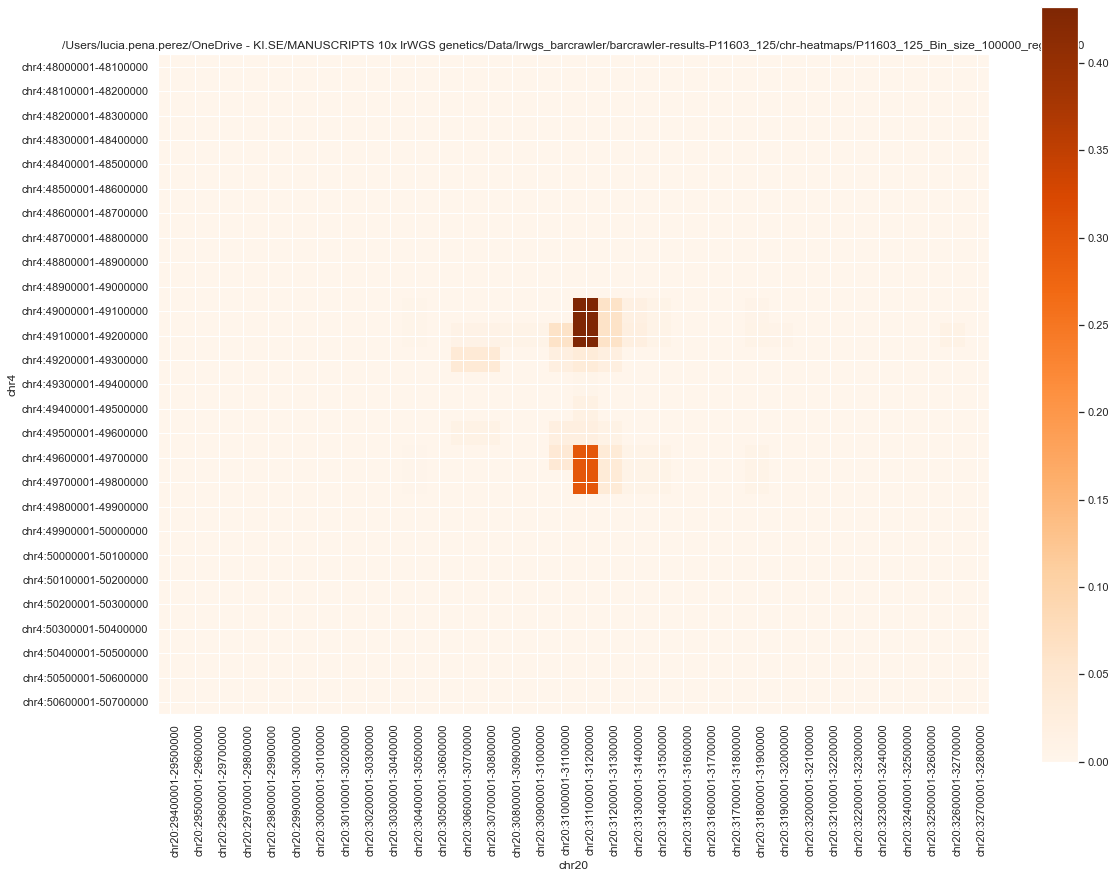

9.0


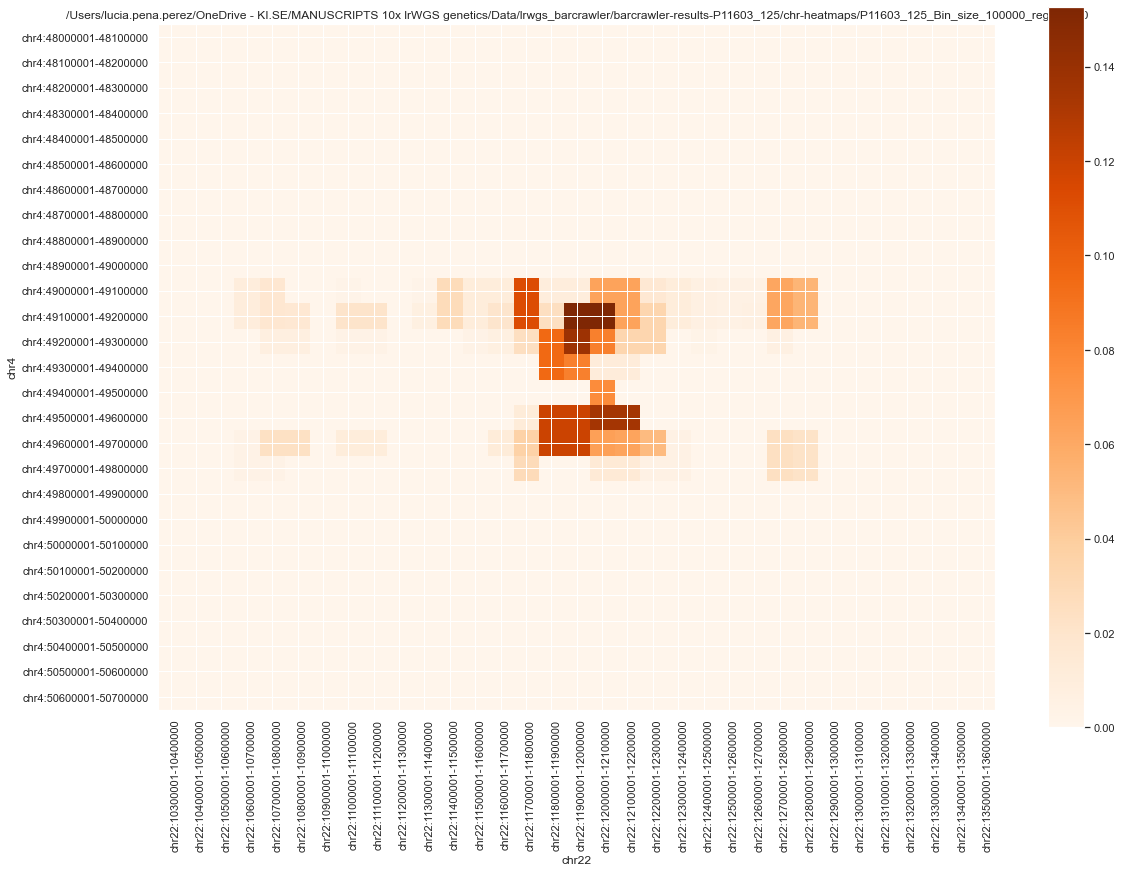

10.0


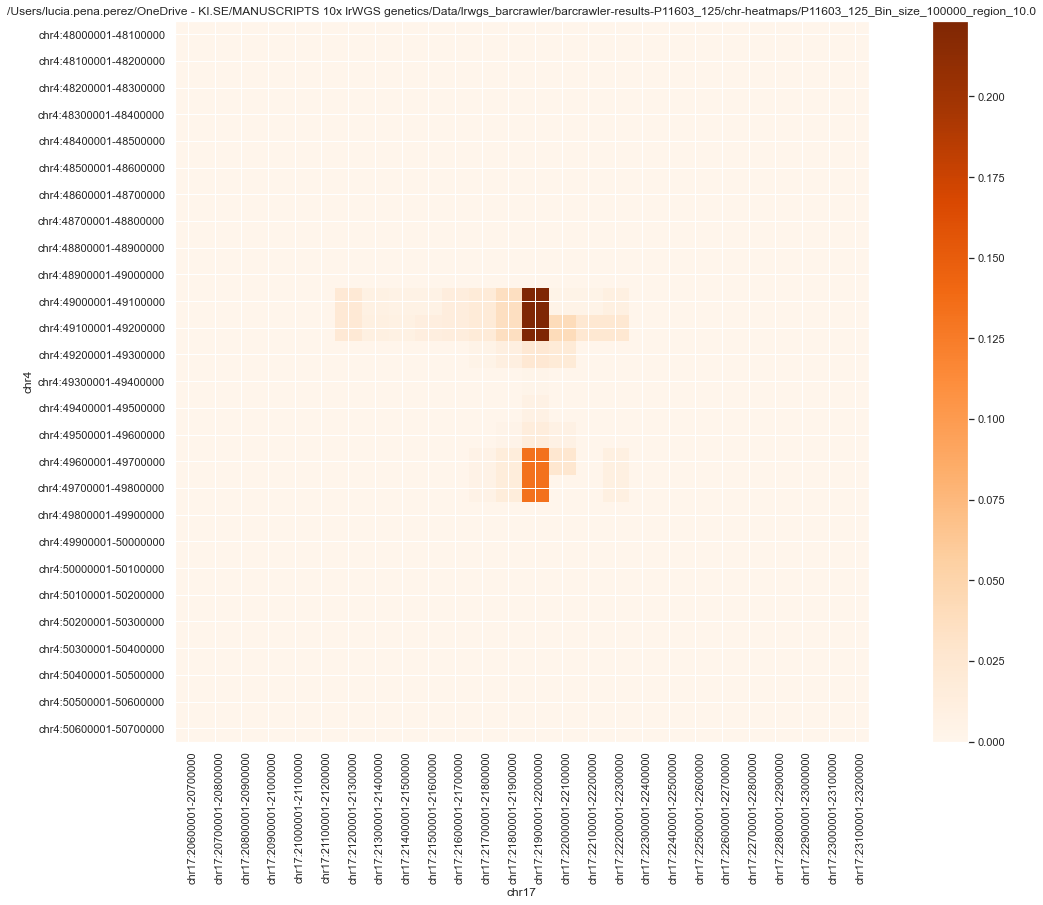

16.0


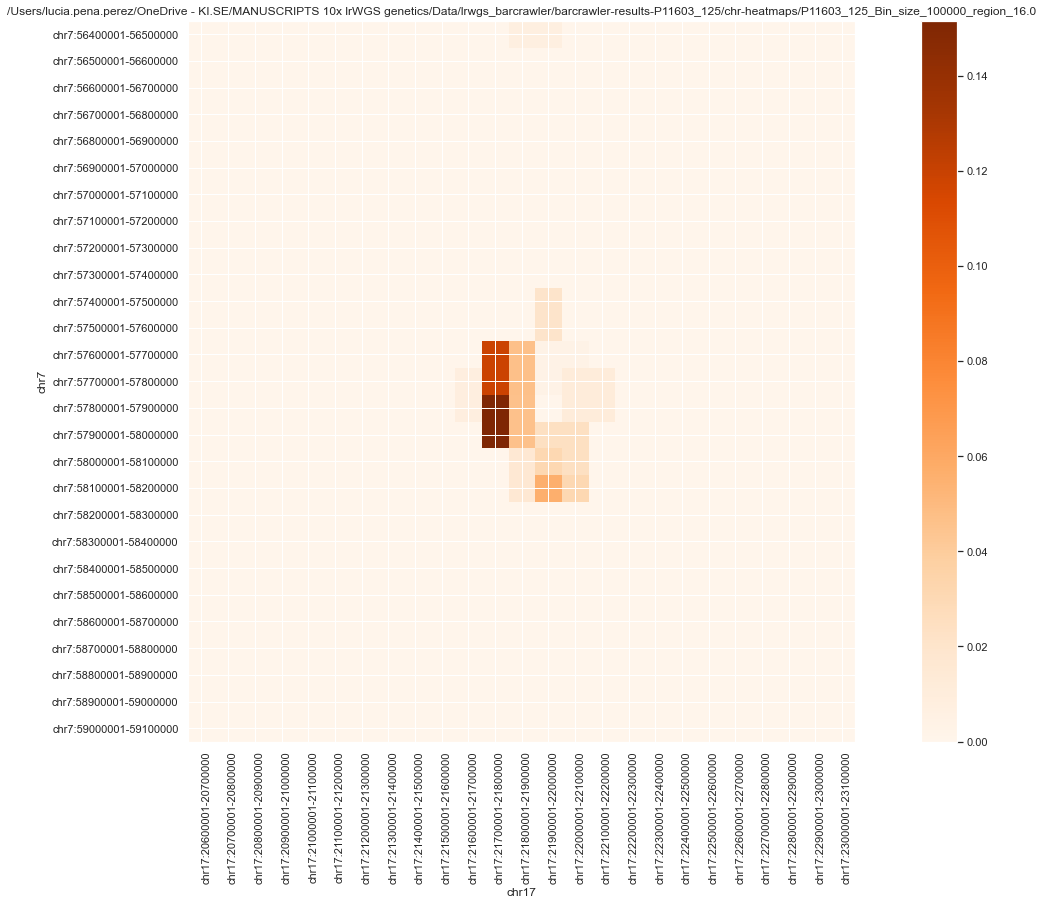

18.0


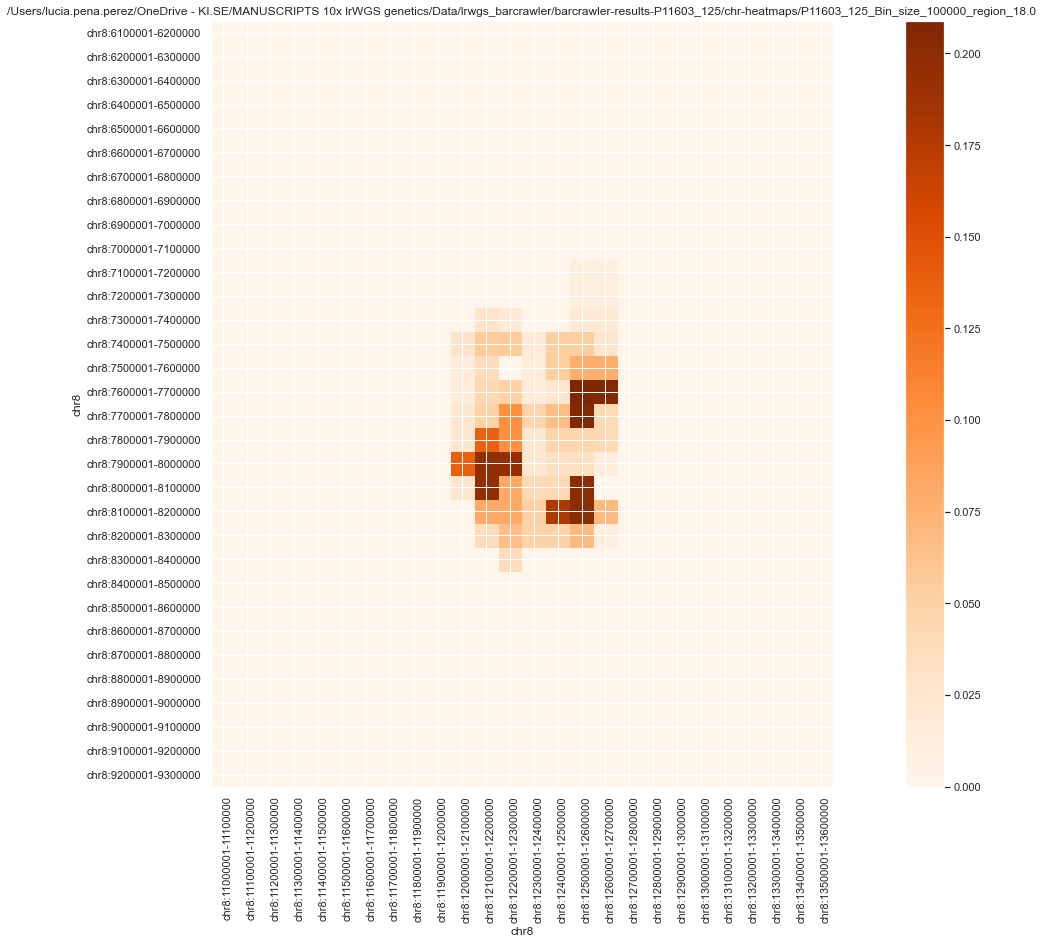

21.0


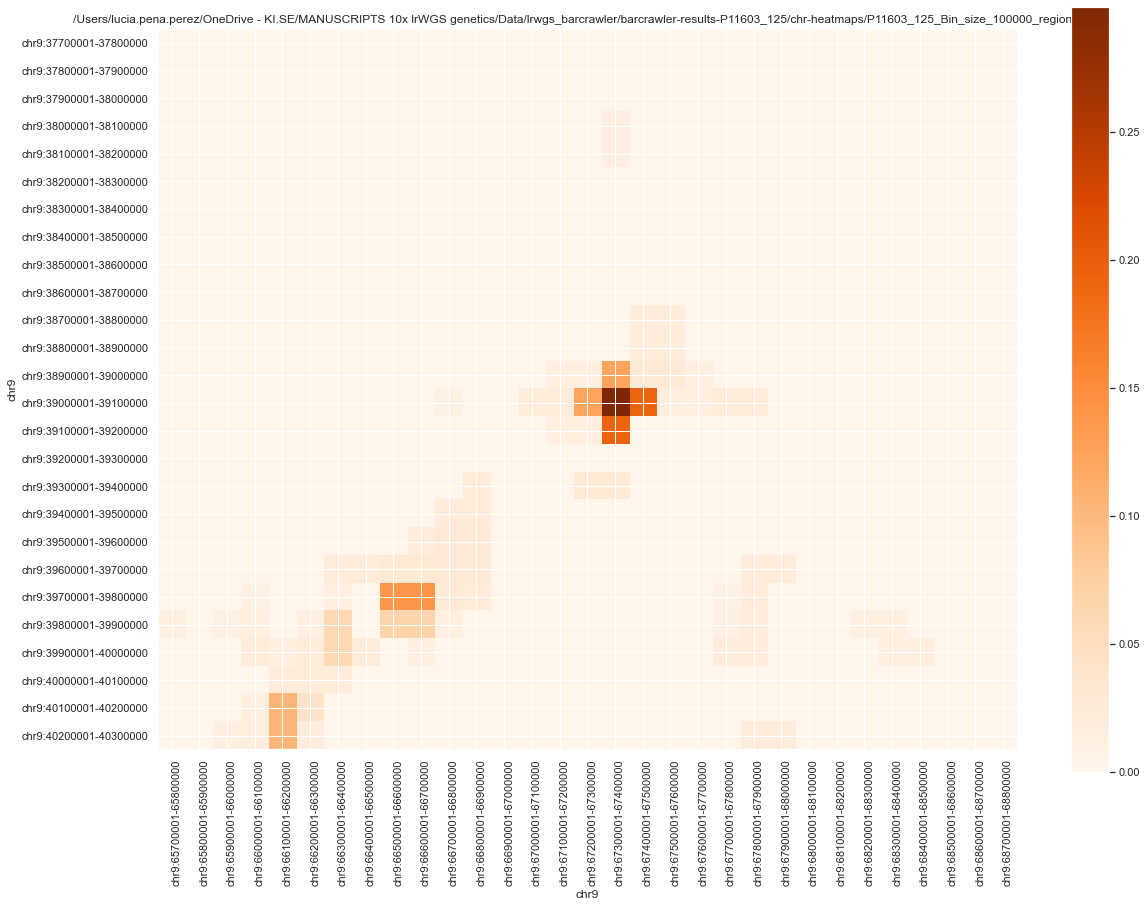

22.0


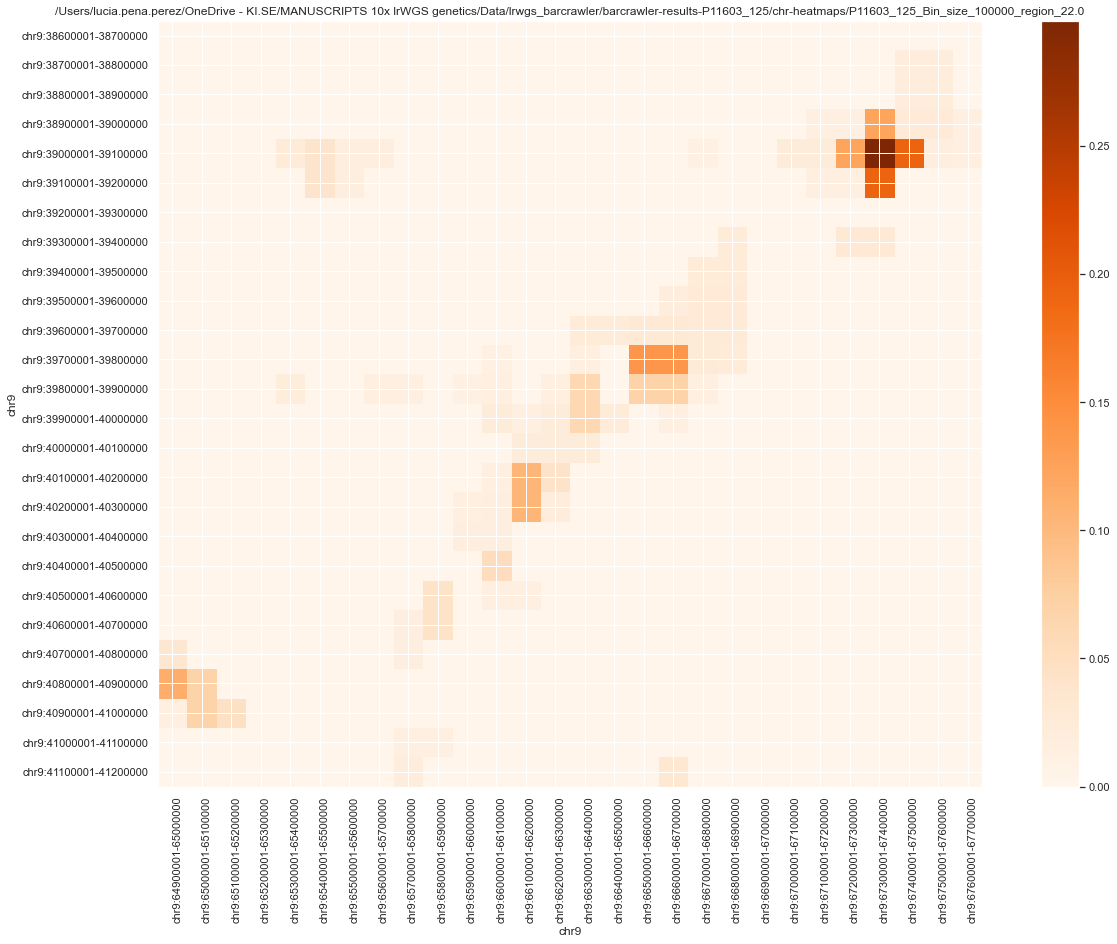

23.0


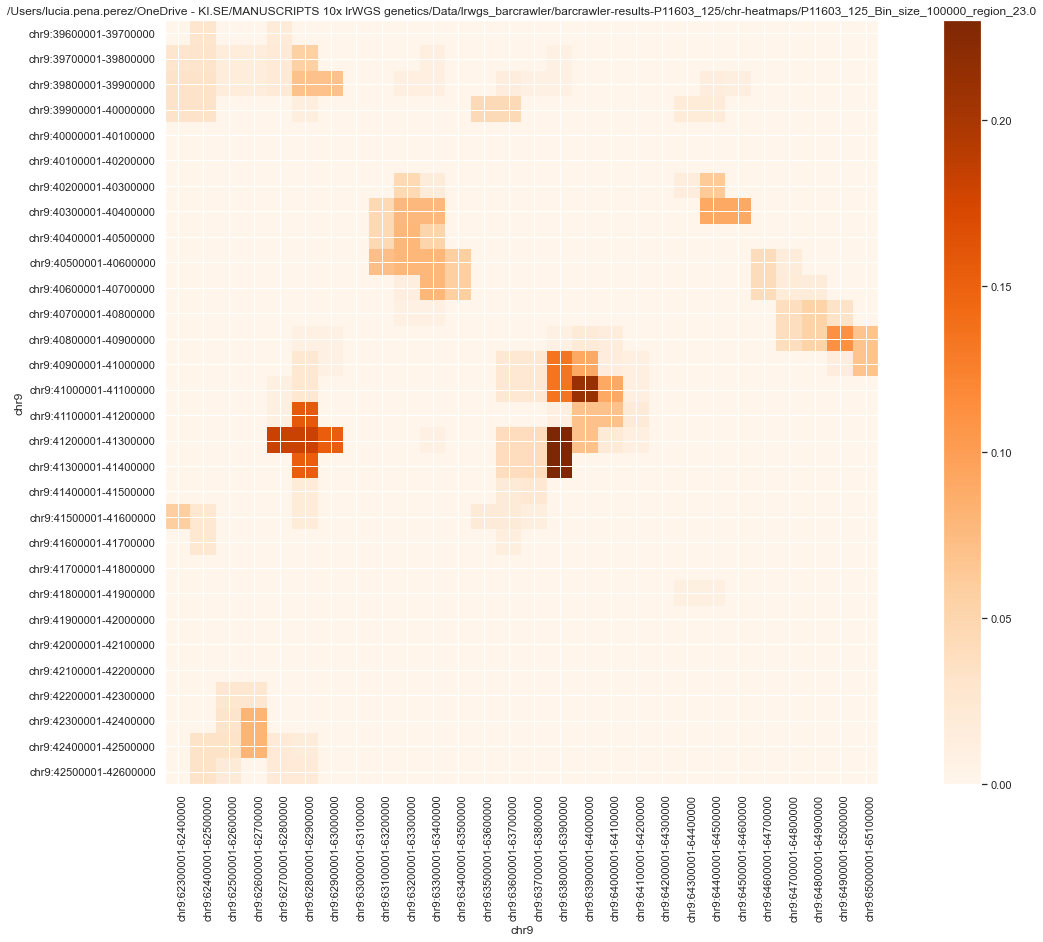

25.0


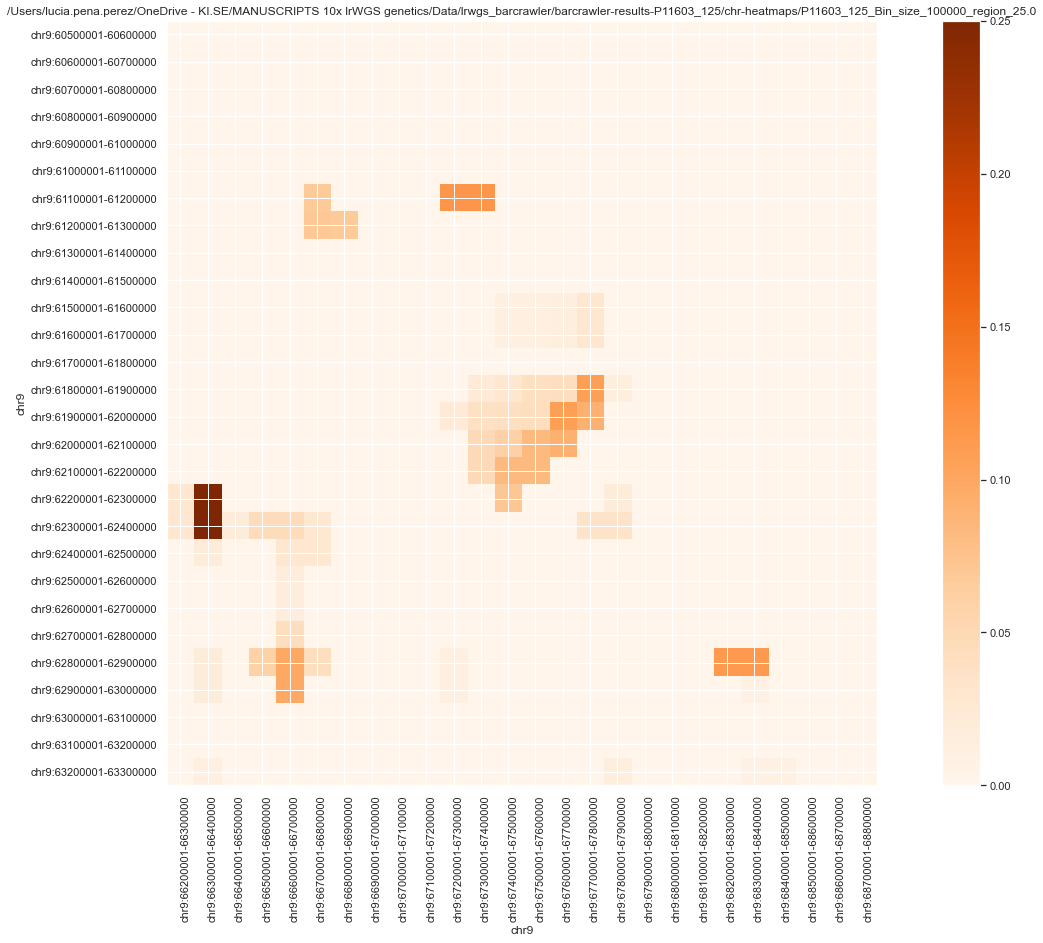

34.0


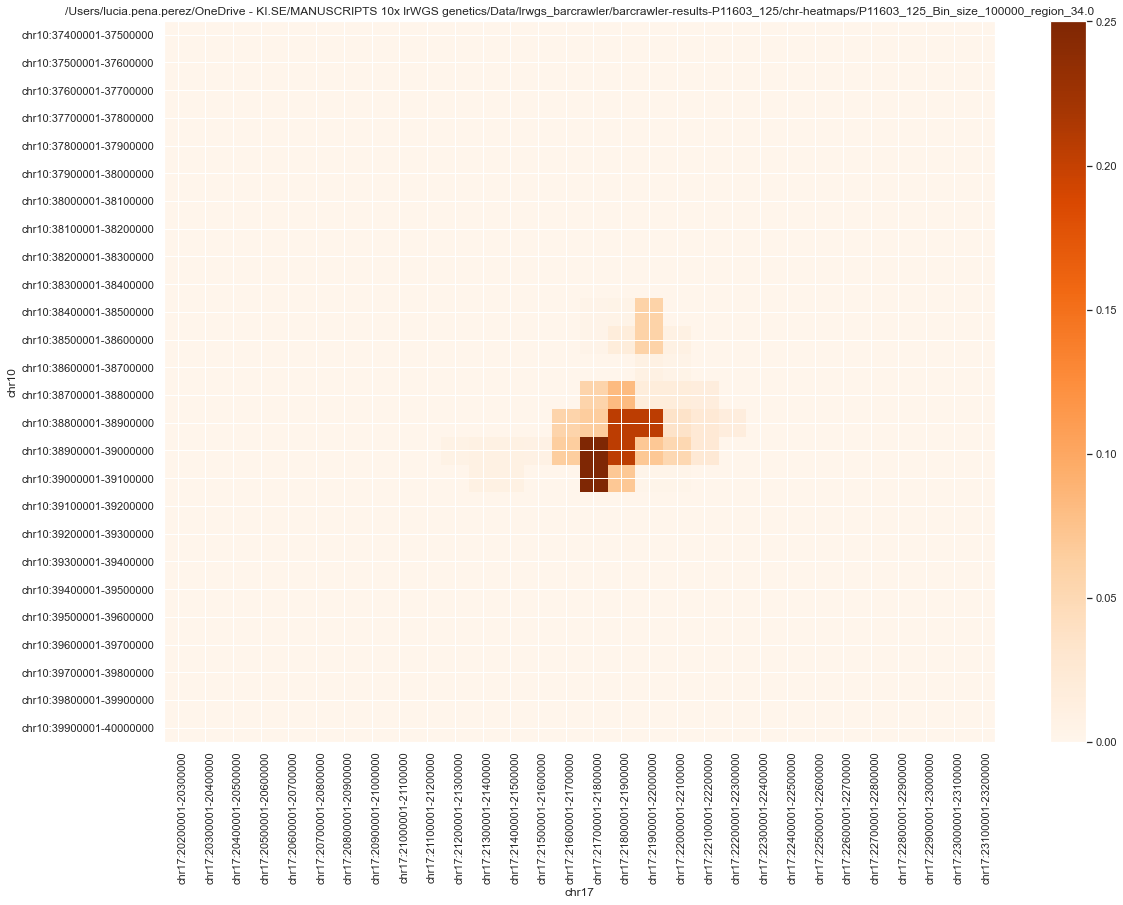

36.0


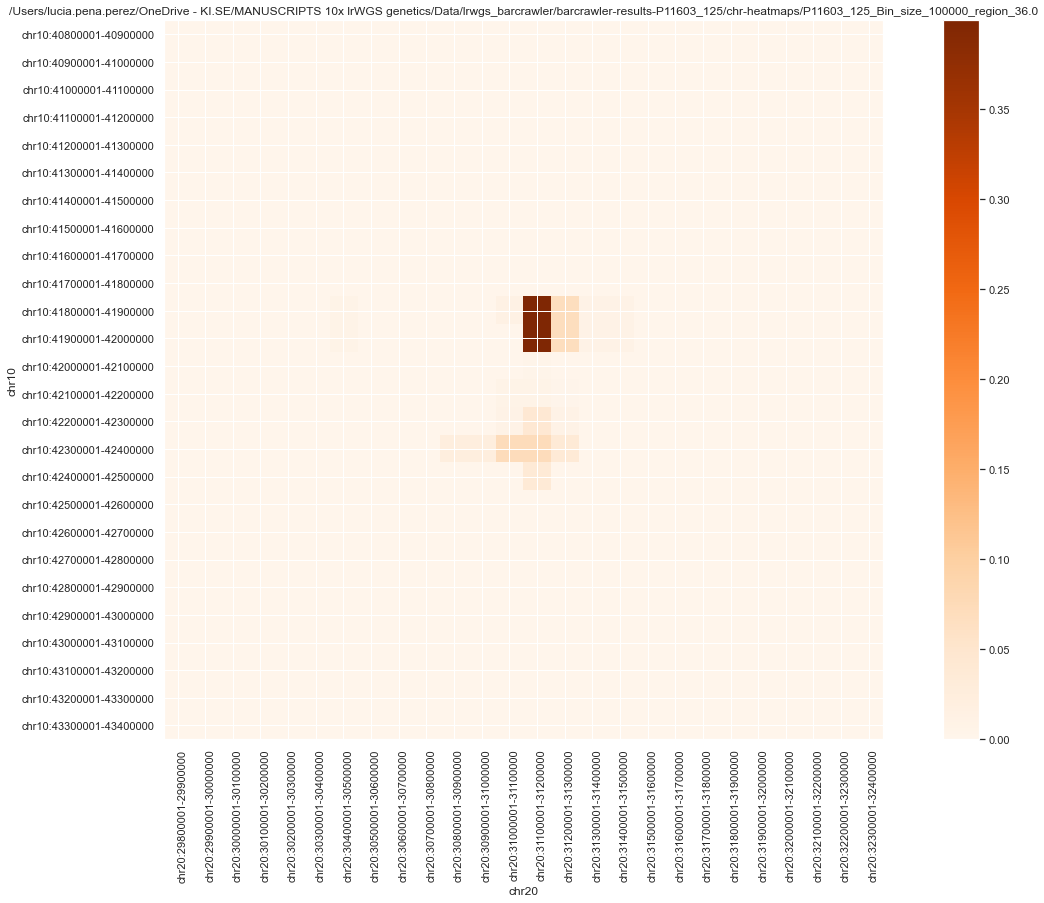

38.0


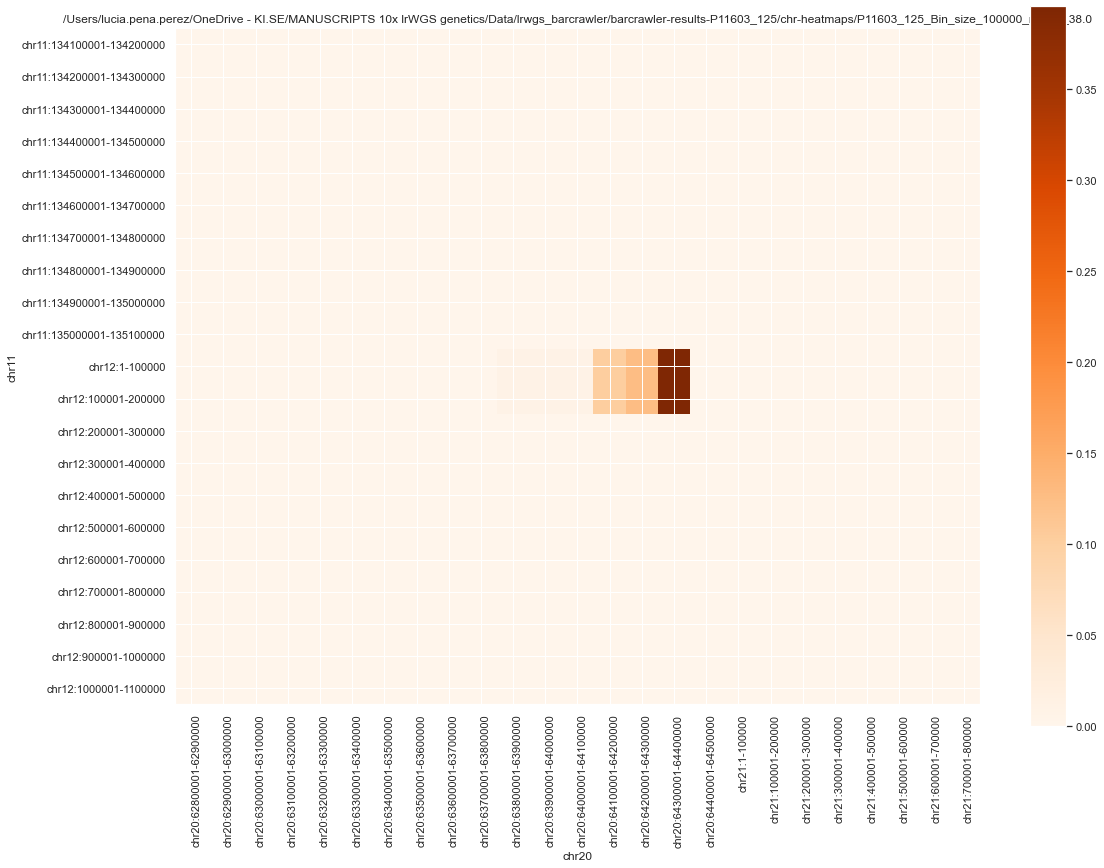

40.0


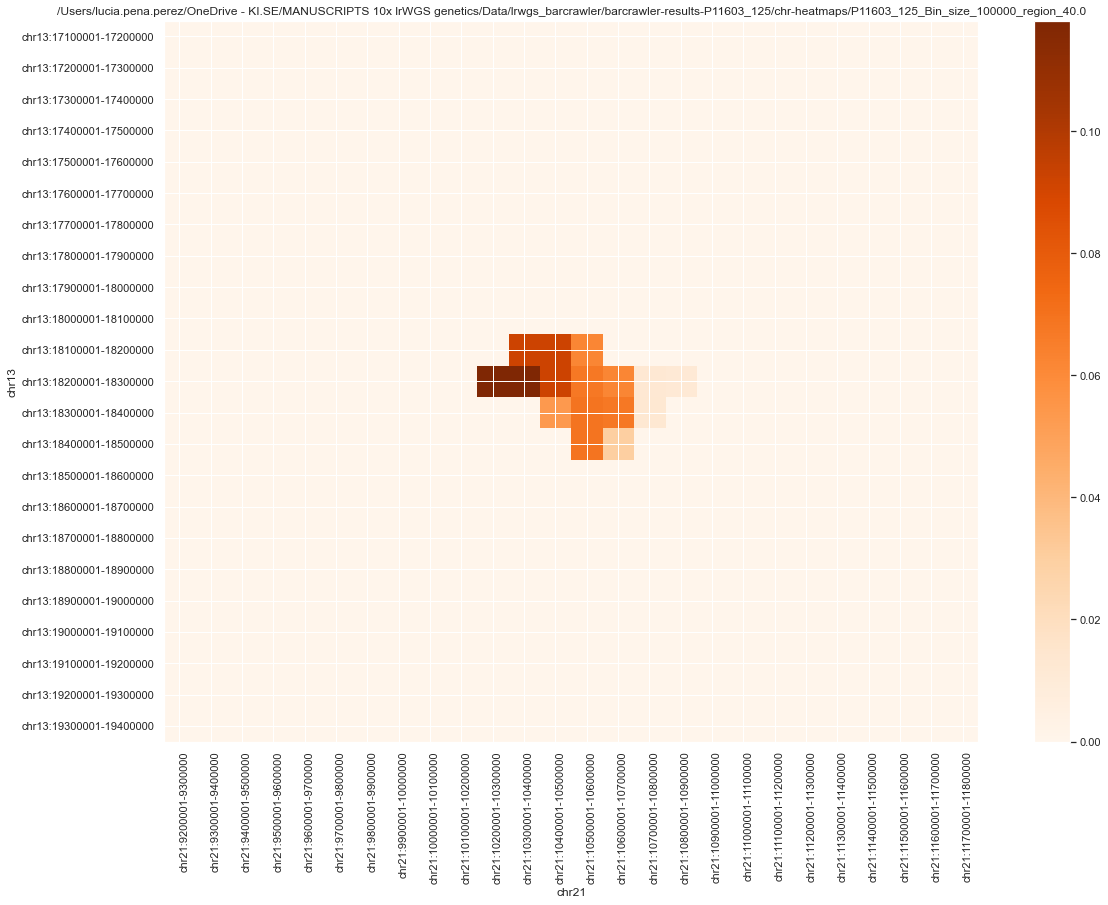

43.0


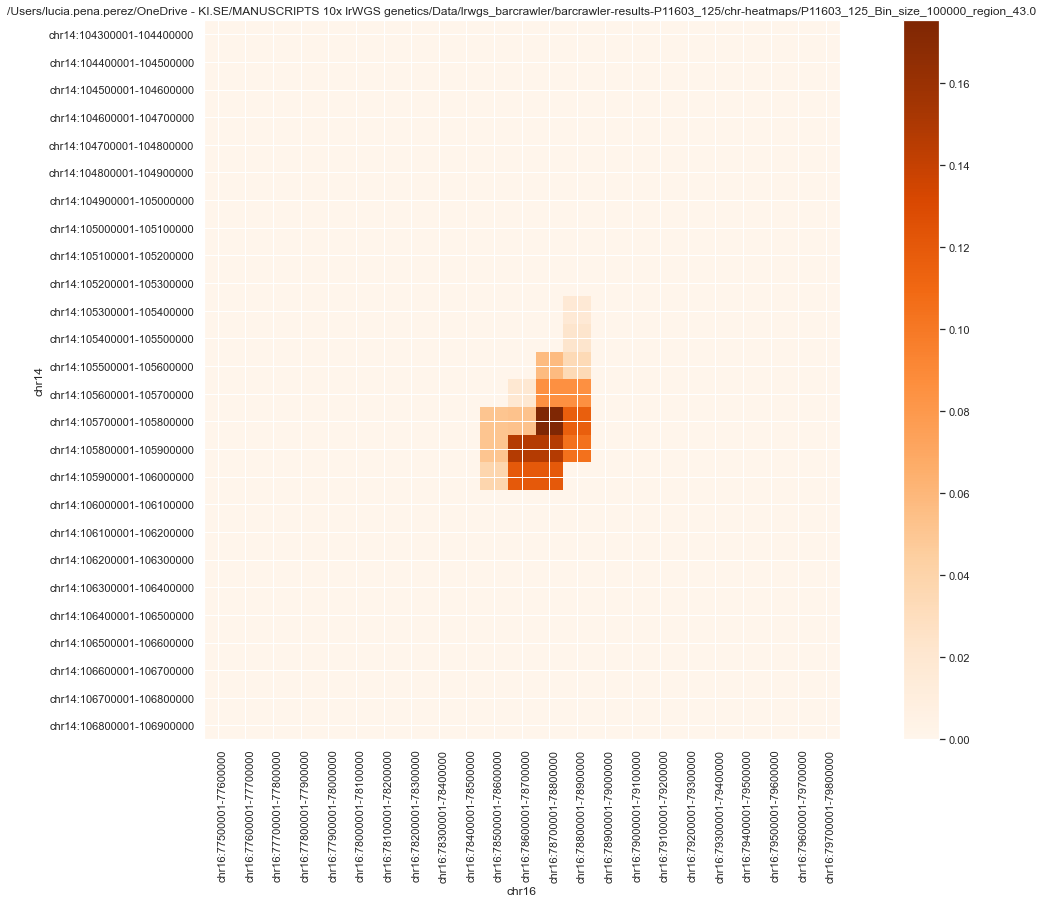

45.0


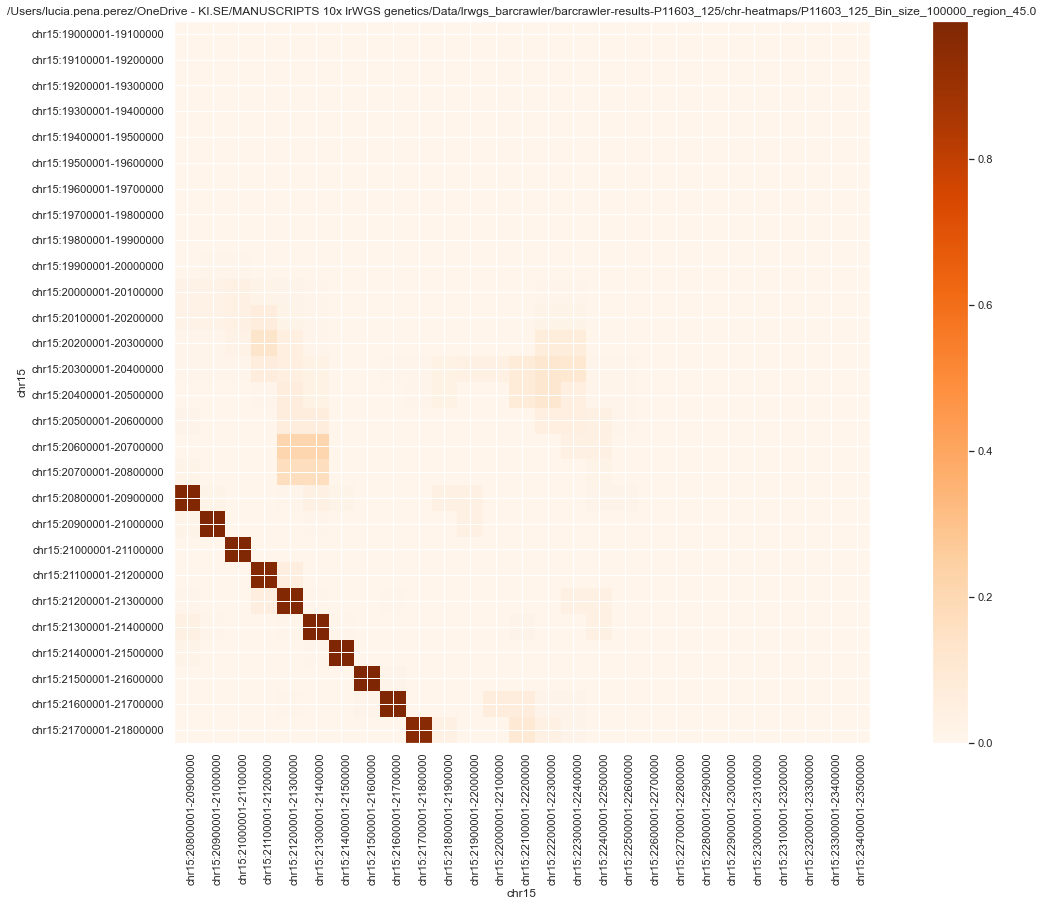

66.0


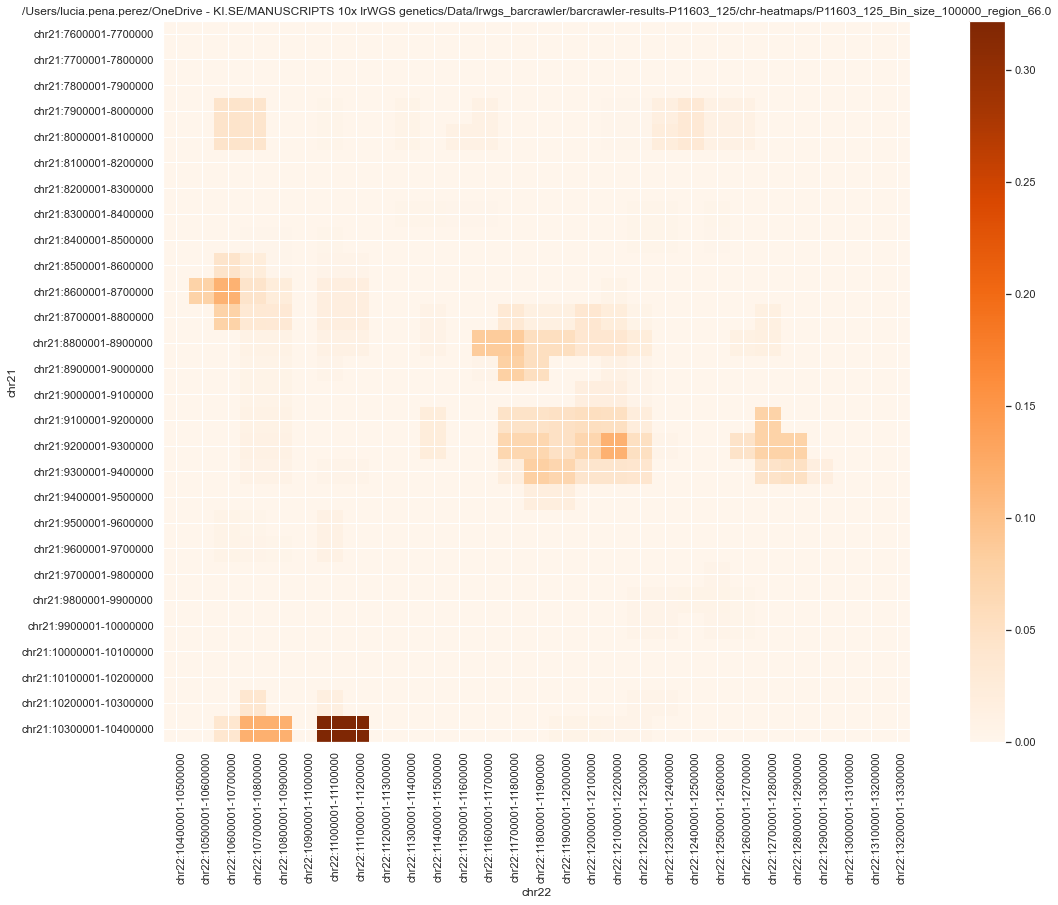

In [292]:
# Outputting clusters identified by DBSCAN where putative SVs are located
if len(int_points)>=0:
    int_points=np.asarray(int_points)
    print("Number of clusters") 
    print(len(int_points))
    for i in int_points:
        print(i)
        blop_cols=cols_ima[labels==i]
        blop_rows=rows_ima[labels==i]
        image_name=path+patient+"/chr-heatmaps/"+patient+"_Bin_size_"+str(bin_size)+"_region_"+str(i)
        if blop_rows.min()<10:
            bl_rws=np.arange(0,20)
        elif blop_rows.max()>(final_dataframe_filt.shape[0]-10):
            bl_rws=np.arange((blop_rows.min()-20),final_dataframe_filt.shape[0])
        else:
            bl_rws=np.arange((blop_rows.min()-10),(blop_rows.max()+10))
        
        if blop_cols.min()<10:
            bl_cls=np.arange(0,20)
        elif blop_cols.max()>(final_dataframe_filt.shape[0]-10):
            bl_cls=np.arange((blop_cols.min()-20),final_dataframe_filt.shape[0])
        else:
            bl_cls=np.arange((blop_cols.min()-10),(blop_cols.max()+10))
        HM_bins(dataframe=final_dataframe_filt.iloc[bl_rws,bl_cls], name_png=image_name)
else:
    print("No SVs found!")